<a href="https://colab.research.google.com/github/Radhika082004/FLAM-Assignment/blob/main/FLAM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
!pip install rembg --quiet
!pip install opencv-python-headless --quiet
!pip install pillow --quiet
!pip install scikit-image --quiet
!pip install onnxruntime --quiet

In [113]:
import cv2
import numpy as np
from rembg import remove
from PIL import Image, ImageFilter, ImageEnhance, ImageOps
import matplotlib.pyplot as plt

In [114]:
bg_path = "/content/B1.jpg"
fg_path = "/content/P2.jpg"

background = Image.open(bg_path).convert("RGB")
person_orig = Image.open(fg_path).convert("RGB")

In [115]:
#Background Removal
person_nobg = remove(person_orig).convert("RGBA")
person_rgb = person_nobg.convert("RGB")
person_alpha = person_nobg.getchannel("A")

In [116]:
# Enhance color & contrast for natural vibrance
enhancer_color = ImageEnhance.Color(person_rgb)
person_rgb_boosted = enhancer_color.enhance(1.05)

enhancer_contrast = ImageEnhance.Contrast(person_rgb_boosted)
person_rgb_boosted = enhancer_contrast.enhance(1.1)

In [117]:
# Force solid alpha where person is visible
person_alpha_corrected = person_alpha.point(lambda p: 255 if p > 10 else 0)
person_colored = Image.merge("RGBA", (*person_rgb_boosted.split(), person_alpha_corrected))

In [118]:
# Resize and position
scale_factor = 0.65
person_colored = person_colored.resize(
    (int(person_colored.width * scale_factor), int(person_colored.height * scale_factor)),
    resample=Image.LANCZOS
)

person_x = 300
person_y = background.height - person_colored.height - 30

In [119]:
# Contact shadow (under feet)
def generate_contact_shadow(mask, blur=15, opacity=120):
    shadow = mask.convert("L").point(lambda p: opacity if p > 0 else 0)
    shadow = shadow.crop((0, mask.height - 30, mask.width, mask.height))
    shadow = shadow.filter(ImageFilter.GaussianBlur(blur))
    full_shadow = Image.new("L", mask.size)
    full_shadow.paste(shadow, (0, mask.height - 30))
    return full_shadow

In [120]:
# Directional shadow (sunset)
def generate_soft_shadow(mask, dx=80, dy=60, blur=91, opacity=80):
    shadow = mask.convert("L").point(lambda p: opacity if p > 0 else 0)
    shadow = shadow.transform(shadow.size, Image.AFFINE, (1, 0, dx, 0, 1, dy))
    shadow = shadow.filter(ImageFilter.GaussianBlur(blur))
    return shadow

In [121]:
# Light wrap (less aggressive)
def apply_sun_glow(person_img, background_img, strength=0.15):
    alpha = person_img.getchannel("A")
    person_rgb = person_img.convert("RGB")
    bg_crop = background_img.crop((person_x, person_y, person_x + person_img.width, person_y + person_img.height))
    bg_blur = bg_crop.filter(ImageFilter.GaussianBlur(25))
    wrap = Image.composite(bg_blur, person_rgb, mask=alpha)
    blend = Image.blend(person_rgb, wrap, strength)
    return Image.merge("RGBA", (*blend.split(), alpha))

In [122]:
# Wet sand reflection
def generate_reflection(person_img, opacity=80, blur=7):
    reflection = person_img.transpose(Image.FLIP_TOP_BOTTOM)
    alpha = reflection.getchannel("A").point(lambda p: int(p * (opacity / 100)))
    reflection = Image.merge("RGBA", (*reflection.convert("RGB").split(), alpha))
    reflection = reflection.filter(ImageFilter.GaussianBlur(blur))
    return reflection

In [123]:
# Apply everything
shadow_main = generate_soft_shadow(person_colored.getchannel("A"))
shadow_contact = generate_contact_shadow(person_colored.getchannel("A"))
person_wrapped = apply_sun_glow(person_colored, background)
reflection = generate_reflection(person_wrapped)

In [124]:
# Final composition
composite = background.copy()

In [125]:
composite.paste(reflection, (person_x, person_y + person_wrapped.height + 10), mask=reflection.getchannel("A"))

In [126]:
composite.paste(Image.merge("RGB", [shadow_main]*3), (person_x, person_y), mask=shadow_main)
composite.paste(Image.merge("RGB", [shadow_contact]*3), (person_x, person_y), mask=shadow_contact)

In [127]:
composite.paste(person_wrapped, (person_x, person_y), mask=person_wrapped.getchannel("A"))

In [128]:
final_path = "/content/final_composite_solid.jpg"
composite.save(final_path)

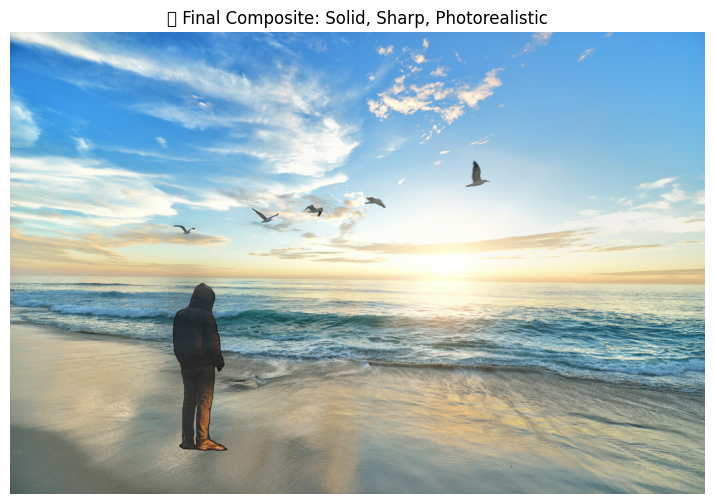

In [129]:
plt.figure(figsize=(10, 6))
plt.imshow(composite)
plt.axis("off")
plt.title("🔥 Final Composite: Solid, Sharp, Photorealistic")
plt.show()